# SAR example
Let's use EOReader with SAR data

<div class="alert alert-warning">
  
<strong>Warning:</strong> 
   <li> We do not provide COSMO-SkyMed data.
   <li> You will need <strong>matplotlib</strong> to complete this tutorial
</div>

In [1]:
import os

# First of all, we need some VHR data, let's use some COSMO-SkyMed data
path = os.path.join("/home", "data", "DATA", "PRODS", "COSMO", "1st_GEN", "1001512-735097")

In [2]:
# Create logger
import logging

logger = logging.getLogger("eoreader")
logger.setLevel(logging.INFO)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)

# create formatter
formatter = logging.Formatter('%(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

In [3]:
from eoreader.reader import Reader

# Create the reader
eoreader = Reader()

In [4]:
# Open your product
prod = eoreader.open(path, remove_tmp=True)
print(f"Acquisition datetime: {prod.datetime}")
print(f"Condensed name: {prod.condensed_name}")

# Please be aware that EOReader will orthorectify your SAR data with SNAP
# Be sure to have your GPT executable in your path

Acquisition datetime: 2020-10-08 22:40:18.446381
Condensed name: 20201008T224018_CSK_HI_DGM


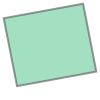

In [5]:
# Open here some more interesting geographical data: extent
extent = prod.extent
extent.geometry.to_crs("EPSG:4326").iat[0]  # Display

Executing processing graph


.

.

.

.

10%

.

.

.

.

20%

.

.

.

.

30%

.

.

.

.

40%

.

.

.

.

50%

.

.

.

.

60%

.

.

.

.

70%

.

.

.

.

80%

.

.

.

.

90%

 done.


make_valid not available in shapely (version 1.7.1 < 1.8). The obtained vector may be broken !


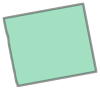

In [6]:
# Open here some more interesting geographical data: footprint
footprint = prod.footprint
footprint.geometry.to_crs("EPSG:4326").iat[0]  # Display

For SAR data, the footprint needs the orthorectified data !
For that, SNAP uses its own DEM, but you can change it when positionning the `EOREADER_SNAP_DEM_NAME` environment variable. 
Available DEMs are:
- `ACE2_5Min` 
- `ACE30`
- `ASTER 1sec GDEM`
- `Copernicus 30m Global DEM`(buggy for now, do not use it)
- `Copernicus 90m Global DEM`(buggy for now, do not use it)
- `GETASSE30` (by default)
- `SRTM 1Sec HGT`
- `SRTM 3Sec`
- `External DEM`

<div class="alert alert-warning">
  
<strong>Warning:</strong> 
   If `External DEM` is set, you must specify the DEM you want by positioning the `EOREADER_DEM_PATH` to a DEM that can be read by SNAP.
</div>
    


In [7]:
from eoreader.bands import *
from eoreader.env_vars import DEM_PATH

# Set the DEM
os.environ[DEM_PATH] = os.path.join("/home", "data", "DS2", "BASES_DE_DONNEES", "GLOBAL", "MERIT_Hydrologically_Adjusted_Elevations", "MERIT_DEM.vrt")

# Select the bands you want to load
bands = [VV, HH, VV_DSPK, HH_DSPK, HILLSHADE, SLOPE]

# Be sure they exist for COSMO-SkyMed sensor:
ok_bands = [band for band in bands if prod.has_band(band)]
print(to_str(ok_bands)) # This product does not have VV band and HILLSHADE band cannot be computed from SAR band

['HH', 'HH_DSPK', 'SLOPE']


In [8]:
# Load those bands as a dict of xarray.DataArray, with a 20m resolution
band_dict = prod.load(ok_bands, resolution=20.)
band_dict[HH]

Executing processing graph


first_line_time metadata value is null
last_line_time metadata value is null
...10%...21%...32%...43%.

.

.

54%.

..

65%

.

..

76%.

.

.87%

.

 done.


<xarray.DataArray 'HH' (band: 1, y: 2474, x: 2689)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 2.058e+05 2.059e+05 ... 2.596e+05 2.596e+05
  * y            (y) float64 1.746e+06 1.746e+06 ... 1.697e+06 1.697e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     HH

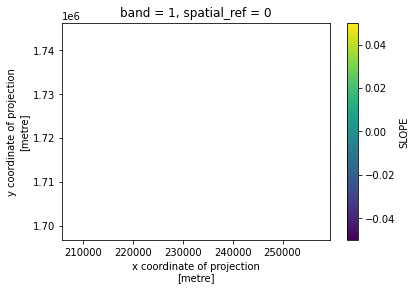

In [9]:
# Plot a subsampled version
band_dict[SLOPE][:, ::10, ::10].plot()

In [10]:
# You can also stack those bands
stack = prod.stack(ok_bands)
stack

<xarray.DataArray 'HH_HH_DSPK_SLOPE' (z: 3, y: 9897, x: 10755)>
dask.array<transpose, shape=(3, 9897, 10755), dtype=float32, chunksize=(1, 3299, 3585), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 2.058e+05 2.058e+05 ... 2.596e+05 2.596e+05
  * y            (y) float64 1.746e+06 1.746e+06 ... 1.697e+06 1.697e+06
  * z            (z) MultiIndex
  - variable     (z) object 'HH' 'HH_DSPK' 'SLOPE'
  - band         (z) int64 1 1 1
Attributes:
    long_name:  ['HH', 'HH_DSPK', 'SLOPE']

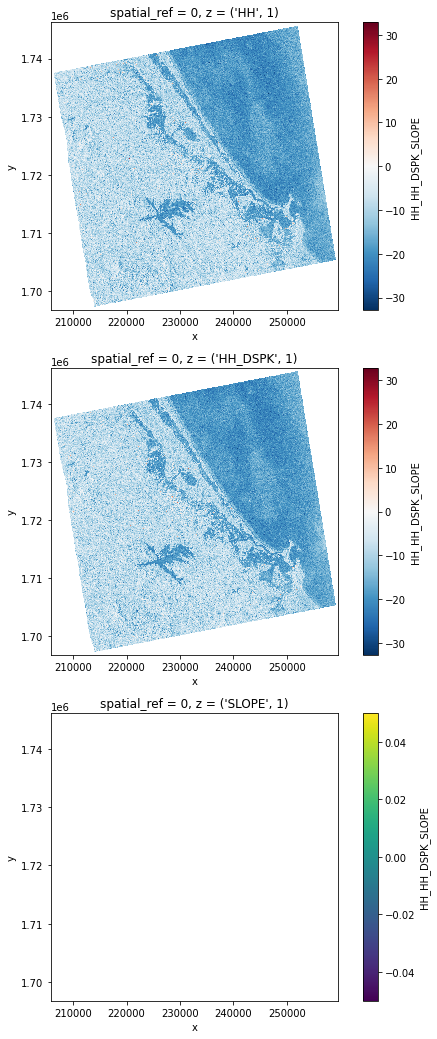

In [11]:
# Error in plotting with a list
if "long_name" in stack.attrs:
    stack.attrs.pop("long_name")

# Plot a subsampled version
import matplotlib.pyplot as plt
nrows = len(stack)
fig, axes = plt.subplots(nrows=nrows, figsize=(3*nrows, 6*nrows), subplot_kw={"box_aspect": 1})
for i in range(nrows):
    stack[i, ::10, ::10].plot(x="x", y="y", ax=axes[i])